In [243]:
import json
import pandas as pd
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import *
import numpy as np

## Setup

In [2]:
train_tw_all = []
train_tw_id = []
train_tw_text = []
train_tw_label = []
with open('data/train/train.txt') as f:
    for line in f:
        split_text = line.strip().split('\t')
        train_tw_all.append({
            'id': split_text[0],
            'text': split_text[2],
            'label': split_text[1]
        })
        train_tw_id.append(split_text[0])
        train_tw_label.append(split_text[1])
        train_tw_text.append(split_text[2])
        
dev_tw_all = []
dev_tw_id = []
dev_tw_text = []
dev_tw_label = []
with open('data/dev/dev.txt') as f:
    for line in f:
        split_text = line.strip().split('\t')
        dev_tw_all.append({
            'id': split_text[0],
            'text': split_text[2],
            'label': split_text[1]
        })
        dev_tw_id.append(split_text[0])
        dev_tw_label.append(split_text[1])
        dev_tw_text.append(split_text[2])

In [3]:
train_tw_all_pd = pd.DataFrame(train_tw_all)

In [5]:
# Store csv file into dataframe. This csv files are converted results from arff file
train_features = pd.read_csv('data/train/train.csv')
dev_features = pd.read_csv('data/dev/dev.csv')

In [6]:
train_adr_data_count = train_features.loc[train_features['class'] == 'Y']['id'].count()
train_nonadr_data_count = train_features.loc[train_features['class'] == 'N']['id'].count()

dev_adr_count = dev_features.loc[dev_features['class'] == 'Y']['id'].count()
dev_nonadr_count = dev_features.loc[dev_features['class'] == 'N']['id'].count()

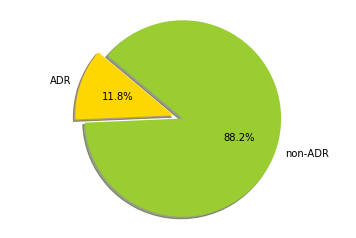

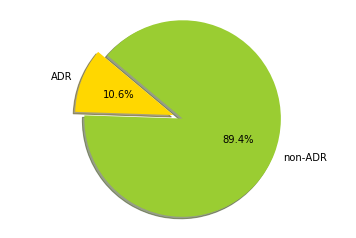

In [7]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = 'ADR', 'non-ADR'
colors = ['gold', 'yellowgreen']
explode = (0.1, 0)  # explode 1st slice
 
# Plot Train Data
plt.pie([train_adr_data_count,train_nonadr_data_count], explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Plot Dev Data
plt.pie([dev_adr_count,dev_nonadr_count], explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()


In [8]:
# Extract label and modify dataframe (remove id and class)

# Training data
train_features_label = train_features['class']
train_features.drop('class', axis = 1, inplace = True)
train_features.drop('id', axis = 1, inplace = True)

In [9]:
train_features_label.value_counts()

N    2793
Y     373
Name: class, dtype: int64

In [10]:
dev_features['class'].value_counts()

N    962
Y    114
Name: class, dtype: int64

## Gaussian Bayes

In [11]:
# Initialise with training data
clf = GaussianNB()
clf.fit(train_features, train_features_label)

GaussianNB(priors=None)

In [12]:
# Extract data without tweet id and class
dev_for_prediction = dev_features[dev_features.columns[1:-1]]
# Extract only class from dev data
dev_class = dev_features[dev_features.columns[-1]]

In [13]:
# Feed dev data into algorithm for evaluation
dev_pred_GNB = clf.predict(dev_for_prediction)

In [14]:
# Confusion matrix for GaussianBayes
GaussianCM = confusion_matrix(dev_class, dev_pred_GNB, labels = ["Y","N"])
GaussianCM

array([[ 39,  75],
       [ 50, 912]])

In [15]:
pd.Series(dev_pred_GNB).value_counts()

N    987
Y     89
dtype: int64

In [16]:
print(classification_report(dev_class,dev_pred_GNB, labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.44      0.34      0.38       114
          N       0.92      0.95      0.94       962

avg / total       0.87      0.88      0.88      1076



In [239]:
accuracy_score(dev_class,dev_pred_GNB)

0.88382899628252787

In [246]:
average_precision_score(np.array(dev_class), np.array(dev_pred_GNB))

ValueError: Data is not binary and pos_label is not specified

array(['N', 'N', 'N', ..., 'N', 'Y', 'N'], dtype=object)

## Multinomial Bayes

In [19]:
clfMulti = MultinomialNB()
clfMulti.fit(train_features, train_features_label)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [20]:
dev_pred_MNB = clfMulti.predict(dev_for_prediction)

In [21]:
MultiNBCM = confusion_matrix(dev_class,dev_pred_MNB, labels = ["Y","N"])
MultiNBCM

array([[ 31,  83],
       [ 26, 936]])

In [22]:
pd.Series(dev_pred_MNB).value_counts()

N    1019
Y      57
dtype: int64

In [23]:
print(classification_report(dev_class,dev_pred_MNB, labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.54      0.27      0.36       114
          N       0.92      0.97      0.94       962

avg / total       0.88      0.90      0.88      1076



In [24]:
accuracy_score(dev_class,dev_pred_MNB)

0.89869888475836435

## Decision Tree

In [25]:
from sklearn import tree

In [26]:
# Default Tree setup
tree_clf = tree.DecisionTreeClassifier()
tree_clf.fit(train_features, train_features_label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [27]:
# check for overfitting by predicting on itself and see how it does with development
train_prediction_descTree = tree_clf.predict(train_features)

In [28]:
print(classification_report(train_features_label ,train_prediction_descTree,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.99      0.82      0.90       373
          N       0.98      1.00      0.99      2793

avg / total       0.98      0.98      0.98      3166



In [29]:
dev_prediction_descTree = tree_clf.predict(dev_for_prediction)

In [30]:
confusion_matrix(dev_class, dev_prediction_descTree,labels = ["Y","N"])

array([[ 31,  83],
       [ 62, 900]])

In [31]:
print(classification_report(dev_class ,dev_prediction_descTree,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.33      0.27      0.30       114
          N       0.92      0.94      0.93       962

avg / total       0.85      0.87      0.86      1076



In [32]:
accuracy_score(dev_class, dev_prediction_descTree)

0.86524163568773238

In [33]:
# Set maximum depth
tree_clf_md = tree.DecisionTreeClassifier(max_depth = 23)
tree_clf_md.fit(train_features, train_features_label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=23,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [34]:
dev_prediction_mdTree = tree_clf_md.predict(dev_for_prediction)

In [35]:
confusion_matrix(dev_class, dev_prediction_mdTree,labels = ["Y","N"])

array([[ 20,  94],
       [ 23, 939]])

In [36]:
print(classification_report(dev_class ,dev_prediction_mdTree,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.47      0.18      0.25       114
          N       0.91      0.98      0.94       962

avg / total       0.86      0.89      0.87      1076



In [37]:
accuracy_score(dev_class, dev_prediction_mdTree)

0.89126394052044611

In [38]:
# Export Decision Trees
with open("tree.dot", 'w') as f:
    f = tree.export_graphviz(tree_clf_md, out_file=f)

## Random Forest

In [148]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=25)
rf.fit(train_features, train_features_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [149]:
dev_prediction_rf = rf.predict(dev_for_prediction)

In [150]:
confusion_matrix(dev_class, dev_prediction_rf, labels = ["Y","N"])

array([[ 14, 100],
       [ 10, 952]])

In [151]:
print(classification_report(dev_class,dev_prediction_rf,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.58      0.12      0.20       114
          N       0.90      0.99      0.95       962

avg / total       0.87      0.90      0.87      1076



In [152]:
accuracy_score(dev_class, dev_prediction_rf)

0.89776951672862448

## Support Vector Machine

In [153]:
from sklearn import svm
svm_clf = svm.LinearSVC()
svm_clf.fit(train_features,train_features_label)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [154]:
dev_prediction_svm = svm_clf.predict(dev_for_prediction)

In [155]:
confusion_matrix(dev_class, dev_prediction_svm,labels = ["Y","N"])

array([[ 22,  92],
       [ 19, 943]])

In [156]:
print(classification_report(dev_class,dev_prediction_svm,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.54      0.19      0.28       114
          N       0.91      0.98      0.94       962

avg / total       0.87      0.90      0.87      1076



In [157]:
accuracy_score(dev_class,dev_prediction_svm)

0.89684014869888473

## Feature Engineering

In [158]:
from sklearn.feature_extraction import DictVectorizer
import twokenize
import string
import re
from collections import Counter 

## ADR Lexicon Features

In [164]:
# Load ADR Lexicon data
adrlex_list = []
with open('data/ADR_lexicon.tsv') as adr_lex:
    n = 0
    for line in adr_lex:
        if n > 20:
            items = line.split('\t')
            if len(items[1])>6:
                _name = string.strip(string.lower(items[1]))
                _cui = string.strip(items[0])
                adrlex_list.append((_cui,_name))
        if n <= 20: n += 1

In [165]:
vec = DictVectorizer()

In [166]:
patterns_dict = {re.compile(ade) : ade for (cui,ade) in adrlex_list}

In [167]:
## Map training data to ADR lexical
train_adr_count = {}
train_adr_presence = {}
train_adr_set = set()

for data in train_tw_all:
    tweet = data['text']
    id = int(data['id'])

    adr_presence = 0
    adr_count = 0
    for pattern in patterns_dict.keys():
        adrs = re.search(pattern,tweet)
        if adrs != None:
            adr_presence = 1
            adr_count += 1
    train_adr_count[id] = adr_count
    train_adr_presence[id] = adr_presence

In [168]:
## Map dev data to ADR lexical
dev_adr_count = {}
dev_adr_presence = {}
dev_adr_set = set()

for data in dev_tw_all:
    tweet = data['text']
    id = int(data['id'])

    adr_presence = 0
    adr_count = 0
    for pattern in patterns_dict.keys():
        adrs = re.search(pattern,tweet)
        if adrs != None:
            adr_presence = 1
            adr_count += 1

    dev_adr_count[id] = adr_count
    dev_adr_presence[id] = adr_presence

In [169]:
## Add two new features to training set
train_features_new = pd.read_csv('data/train/train.csv')
train_features_new['adr_presence'] = train_features_new['id'].map(train_adr_presence)
train_features_new['adr_count'] = train_features_new['id'].map(train_adr_count)
train_features_new.head(n=20)

,id,allergic,am,appetite,bad,bananas,bed,been,body,but,...,up,was,weight,withdrawal,withdrawals,wondering,zombie,class,adr_presence,adr_count
0,326376825590779905,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,N,1,2
1,326398829849092097,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,Y,1,1
2,326406322323066883,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,Y,1,1
3,326407491460141056,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,N,1,2
4,326453069795688449,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,N,0,0
5,326454089124814849,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,N,1,1
6,326456822007492608,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,N,1,1
7,326468307240759296,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,N,0,0
8,326505447643291650,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,N,0,0
9,326523509444591616,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,N,1,1


In [170]:
## Add two new features to training set
dev_features_new = pd.read_csv('data/dev/dev.csv')
dev_features_new['adr_presence'] = dev_features_new['id'].map(dev_adr_presence)
dev_features_new['adr_count'] = dev_features_new['id'].map(dev_adr_count)
dev_features_new.head()

,id,allergic,am,appetite,bad,bananas,bed,been,body,but,...,up,was,weight,withdrawal,withdrawals,wondering,zombie,class,adr_presence,adr_count
0,326379831954661376,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,N,1,1
1,326393333066919936,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,N,0,0
2,326398219192000512,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,N,0,0
3,326446459631321088,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,N,0,0
4,326468233978855426,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,N,0,0


## Sentiment Analysis

In [171]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [172]:
## Map training data to ADR lexical
train_sentiment = {}

for data in train_tw_all:
    tweet = data['text']
    id = int(data['id'])
    
    scores = analyzer.polarity_scores(tweet)
    train_sentiment[id] = 1 if scores['compound'] <= 0.5 else 0

In [173]:
## Map training data to ADR lexical
dev_sentiment = {}

for data in dev_tw_all:
    tweet = data['text']
    id = int(data['id'])
    
    scores = analyzer.polarity_scores(tweet)
    dev_sentiment[id] = 1 if scores['compound'] <= 0.5 else 0

In [174]:
dev_features_new['neg_sent'] = dev_features_new['id'].map(dev_sentiment)
train_features_new['neg_sent'] = train_features_new['id'].map(train_sentiment)

In [175]:
train_features_new.head(n=20)

,id,allergic,am,appetite,bad,bananas,bed,been,body,but,...,was,weight,withdrawal,withdrawals,wondering,zombie,class,adr_presence,adr_count,neg_sent
0,326376825590779905,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,N,1,2,1
1,326398829849092097,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,Y,1,1,0
2,326406322323066883,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,Y,1,1,1
3,326407491460141056,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,N,1,2,1
4,326453069795688449,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,N,0,0,1
5,326454089124814849,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,N,1,1,1
6,326456822007492608,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,N,1,1,1
7,326468307240759296,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,N,0,0,1
8,326505447643291650,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,N,0,0,0
9,326523509444591616,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,N,1,1,1


## Setup Training / Dev Data

### Training

In [176]:
train_feat_adr = train_features_new.copy(deep=True)
train_feat_sent = train_features_new.copy(deep=True)
train_feat_all = train_features_new.copy(deep=True)

train_features_label_new = train_features_new['class']
# Only ADR Lexicon
train_feat_adr.drop('class', axis = 1, inplace = True)
train_feat_adr.drop('id', axis = 1, inplace = True)
train_feat_adr.drop('neg_sent', axis = 1, inplace = True)

# Only with negative sentiment
train_feat_sent.drop('class', axis = 1, inplace = True)
train_feat_sent.drop('id', axis = 1, inplace = True)
train_feat_sent.drop('adr_presence', axis = 1, inplace = True)
train_feat_sent.drop('adr_count', axis = 1, inplace = True)

# All new features
train_feat_all.drop('class', axis = 1, inplace = True)
train_feat_all.drop('id', axis = 1, inplace = True)

### Development

In [181]:
dev_feat_adr = dev_features_new.copy(deep=True)
dev_feat_sent = dev_features_new.copy(deep=True)
dev_feat_all = dev_features_new.copy(deep=True)

dev_class_new = dev_features_new['class']
# Only ADR Lexicon
dev_feat_adr.drop('class', axis = 1, inplace = True)
dev_feat_adr.drop('id', axis = 1, inplace = True)
dev_feat_adr.drop('neg_sent', axis = 1, inplace = True)

# Only with negative sentiment
dev_feat_sent.drop('class', axis = 1, inplace = True)
dev_feat_sent.drop('id', axis = 1, inplace = True)
dev_feat_sent.drop('adr_presence', axis = 1, inplace = True)
dev_feat_sent.drop('adr_count', axis = 1, inplace = True)

# All new features
dev_feat_all.drop('class', axis = 1, inplace = True)
dev_feat_all.drop('id', axis = 1, inplace = True)

# Phase 2 experiment
## Random Forest

In [185]:
rf_clf_adr = RandomForestClassifier(max_depth=25)
rf_clf_adr.fit(train_feat_adr, train_features_label_new)

rf_clf_sent = RandomForestClassifier(max_depth=25)
rf_clf_sent.fit(train_feat_sent, train_features_label_new)

rf_clf_all = RandomForestClassifier(max_depth=25)
rf_clf_all.fit(train_feat_all, train_features_label_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [186]:
dev_pred_adr = rf_clf_adr.predict(dev_feat_adr)
dev_pred_sent = rf_clf_sent.predict(dev_feat_sent)
dev_pred_all = rf_clf_all.predict(dev_feat_all)

In [187]:
confusion_matrix(dev_class_new, dev_pred_adr,labels = ["Y","N"])

array([[ 22,  92],
       [ 15, 947]])

In [188]:
confusion_matrix(dev_class_new, dev_pred_sent,labels = ["Y","N"])

array([[ 12, 102],
       [  9, 953]])

In [189]:
confusion_matrix(dev_class_new, dev_pred_all,labels = ["Y","N"])

array([[ 21,  93],
       [ 14, 948]])

In [190]:
print(classification_report(dev_class_new,dev_pred_adr,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.59      0.19      0.29       114
          N       0.91      0.98      0.95       962

avg / total       0.88      0.90      0.88      1076



In [191]:
print(classification_report(dev_class_new,dev_pred_sent,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.57      0.11      0.18       114
          N       0.90      0.99      0.94       962

avg / total       0.87      0.90      0.86      1076



In [192]:
print(classification_report(dev_class_new,dev_pred_all,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.60      0.18      0.28       114
          N       0.91      0.99      0.95       962

avg / total       0.88      0.90      0.88      1076



In [193]:
accuracy_score(dev_class_new,dev_pred_adr)

0.90055762081784385

In [194]:
accuracy_score(dev_class_new,dev_pred_sent)

0.89684014869888473

In [195]:
accuracy_score(dev_class_new,dev_pred_all)

0.90055762081784385

## SVM

In [197]:
from sklearn import svm
svm_clf_adr = svm.LinearSVC()
svm_clf_adr.fit(train_feat_adr,train_features_label_new)

svm_clf_sent = svm.LinearSVC()
svm_clf_sent.fit(train_feat_sent,train_features_label_new)

svm_clf_all = svm.LinearSVC()
svm_clf_all.fit(train_feat_all,train_features_label_new)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [198]:
dev_pred_svm_adr = svm_clf_adr.predict(dev_feat_adr)
dev_pred_svm_sent = svm_clf_sent.predict(dev_feat_sent)
dev_pred_svm_all = svm_clf_all.predict(dev_feat_all)

In [199]:
confusion_matrix(dev_class_new, dev_pred_svm_adr,labels = ["Y","N"])

array([[ 25,  89],
       [ 15, 947]])

In [200]:
confusion_matrix(dev_class_new, dev_pred_svm_sent,labels = ["Y","N"])

array([[ 22,  92],
       [ 16, 946]])

In [201]:
confusion_matrix(dev_class_new, dev_pred_svm_all,labels = ["Y","N"])

array([[ 25,  89],
       [ 14, 948]])

In [202]:
print(classification_report(dev_class_new,dev_pred_svm_adr,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.62      0.22      0.32       114
          N       0.91      0.98      0.95       962

avg / total       0.88      0.90      0.88      1076



In [203]:
print(classification_report(dev_class_new,dev_pred_svm_sent,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.58      0.19      0.29       114
          N       0.91      0.98      0.95       962

avg / total       0.88      0.90      0.88      1076



In [204]:
print(classification_report(dev_class_new,dev_pred_svm_all,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.64      0.22      0.33       114
          N       0.91      0.99      0.95       962

avg / total       0.89      0.90      0.88      1076



In [205]:
accuracy_score(dev_class_new,dev_pred_svm_adr)

0.90334572490706322

In [206]:
accuracy_score(dev_class_new,dev_pred_svm_sent)

0.8996282527881041

In [207]:
accuracy_score(dev_class_new,dev_pred_svm_all)

0.90427509293680297

## Gaussian NB

In [208]:
clf_adr = GaussianNB()
clf_adr.fit(train_feat_adr, train_features_label_new)

clf_sent = GaussianNB()
clf_sent.fit(train_feat_sent, train_features_label_new)

clf_all = GaussianNB()
clf_all.fit(train_feat_all, train_features_label_new)

GaussianNB(priors=None)

In [209]:
dev_pred_gnb_adr = clf_adr.predict(dev_feat_adr)
dev_pred_gnb_sent = clf_sent.predict(dev_feat_sent)
dev_pred_gnb_all = clf_all.predict(dev_feat_all)

In [210]:
confusion_matrix(dev_class_new, dev_pred_gnb_adr,labels = ["Y","N"])

array([[ 39,  75],
       [ 52, 910]])

In [211]:
confusion_matrix(dev_class_new, dev_pred_gnb_sent,labels = ["Y","N"])

array([[ 39,  75],
       [ 50, 912]])

In [212]:
confusion_matrix(dev_class_new, dev_pred_gnb_all,labels = ["Y","N"])

array([[ 39,  75],
       [ 51, 911]])

In [213]:
print(classification_report(dev_class_new,dev_pred_gnb_adr,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.43      0.34      0.38       114
          N       0.92      0.95      0.93       962

avg / total       0.87      0.88      0.88      1076



In [214]:
print(classification_report(dev_class_new,dev_pred_gnb_sent,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.44      0.34      0.38       114
          N       0.92      0.95      0.94       962

avg / total       0.87      0.88      0.88      1076



In [215]:
print(classification_report(dev_class_new,dev_pred_gnb_all,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.43      0.34      0.38       114
          N       0.92      0.95      0.94       962

avg / total       0.87      0.88      0.88      1076



In [216]:
accuracy_score(dev_class_new,dev_pred_gnb_adr)

0.88197026022304836

In [217]:
accuracy_score(dev_class_new,dev_pred_gnb_sent)

0.88382899628252787

In [218]:
accuracy_score(dev_class_new,dev_pred_gnb_all)

0.88289962825278812

## Multinomial NB

In [219]:
clfMulti_adr = MultinomialNB()
clfMulti_adr.fit(train_feat_adr, train_features_label_new)

clfMulti_sent = MultinomialNB()
clfMulti_sent.fit(train_feat_sent, train_features_label_new)

clfMulti_all = MultinomialNB()
clfMulti_all.fit(train_feat_all, train_features_label_new)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [220]:
dev_multinb_pred_adr = clfMulti_adr.predict(dev_feat_adr)
dev_multinb_pred_sent = clfMulti_sent.predict(dev_feat_sent)
dev_multinb_pred_all = clfMulti_all.predict(dev_feat_all)

In [221]:
confusion_matrix(dev_class_new, dev_multinb_pred_adr,labels = ["Y","N"])

array([[ 34,  80],
       [ 27, 935]])

In [222]:
confusion_matrix(dev_class_new, dev_multinb_pred_sent,labels = ["Y","N"])

array([[ 31,  83],
       [ 31, 931]])

In [223]:
confusion_matrix(dev_class_new, dev_multinb_pred_all,labels = ["Y","N"])

array([[ 32,  82],
       [ 29, 933]])

In [224]:
print(classification_report(dev_class_new,dev_multinb_pred_adr,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.56      0.30      0.39       114
          N       0.92      0.97      0.95       962

avg / total       0.88      0.90      0.89      1076



In [225]:
print(classification_report(dev_class_new,dev_multinb_pred_sent,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.50      0.27      0.35       114
          N       0.92      0.97      0.94       962

avg / total       0.87      0.89      0.88      1076



In [226]:
print(classification_report(dev_class_new,dev_multinb_pred_all,labels = ["Y","N"]))

             precision    recall  f1-score   support

          Y       0.52      0.28      0.37       114
          N       0.92      0.97      0.94       962

avg / total       0.88      0.90      0.88      1076



In [227]:
accuracy_score(dev_class_new,dev_multinb_pred_adr)

0.90055762081784385

In [228]:
accuracy_score(dev_class_new,dev_multinb_pred_sent)

0.89405204460966547

In [229]:
accuracy_score(dev_class_new,dev_multinb_pred_all)

0.89684014869888473

### Decision Tree

In [257]:
tree_adr = tree.DecisionTreeClassifier(max_depth=25, splitter='random')
tree_adr.fit(train_feat_adr, train_features_label_new)

tree_sent = tree.DecisionTreeClassifier(max_depth=25,splitter='random')
tree_sent.fit(train_feat_sent, train_features_label_new)

tree_all = tree.DecisionTreeClassifier(max_depth=25,splitter='random')
tree_all.fit(train_feat_all, train_features_label_new)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=25,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')

In [258]:
dev_pred_dt_adr = tree_adr.predict(dev_feat_adr)
dev_pred_dt_sent = tree_sent.predict(dev_feat_sent)
dev_pred_dt_all = tree_all.predict(dev_feat_all)

In [259]:
accuracy_score(dev_class_new,dev_pred_dt_adr)

0.89312267657992561

In [260]:
accuracy_score(dev_class_new,dev_pred_dt_sent)

0.88382899628252787

In [261]:
accuracy_score(dev_class_new,dev_pred_dt_all)

0.88197026022304836